# SCC-ICMC-USP - 1st. Semester - 2023
# SCC5948/MAI5024. Data Science - Final Work – **01.** Pre-Processing

### Prof. PhD. Roseli Aparecida Francelin Romero

### Monitor: Diogo Godoi

Group Number: 12

Students:

1.   Leandro Marcos da Silva (**13702000**)
2.   Vinícius Andreghetti (**9898012**)

In [1]:
# Imports
from imblearn.under_sampling import RandomUnderSampler
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from utils import txt_to_list, read_data, split_X_y # utils.py

import numpy as np
import pandas as pd
import warnings


# Ignore Pandas warnings
warnings.filterwarnings("ignore")

# Random state default
RANDOM_STATE = 42

## Functions

In [2]:
def convert_label_to_numeric(x):
    if x == 'Normal': # Normal label
        return 0
    else:
        return 1 # Evil Twin label



def drop_highly_correlated_features(X):
    # Create correlation matrix
    corr_matrix = X.corr(numeric_only=False).abs()
    # Select upper traingle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Find index of columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    # Drop the columns
    X.drop(columns=list(to_drop), axis=1, inplace=True)
    # Return X after dropping columns with high correlation
    return X




def pre_processing(df):
    # Drop constant columns
    df = df.loc[:, df.apply(pd.Series.nunique) != 1]
    # Drop rows with null labels
    df.dropna(subset=['Label'], inplace=True)
    
    # Carry out the treatment of the 'radiotap.dbm_antsignal' column
    # Convert to string to use split
    df['radiotap.dbm_antsignal'] = df['radiotap.dbm_antsignal'].astype(str)
    # Get only the first occurrence of the value
    df['radiotap.dbm_antsignal'] = df['radiotap.dbm_antsignal'].str.split('-').str[1]
    # Add the negative sign (-)
    df['radiotap.dbm_antsignal'] = '-' + df['radiotap.dbm_antsignal']
     # Convert back to float, because it is numeric
    df['radiotap.dbm_antsignal'] = df['radiotap.dbm_antsignal'].astype(float)

    # Create the pipelines
    numerical_pipeline = Pipeline(steps=[ # Numerical pipeline
        ('imputer', SimpleImputer(strategy='mean')), # Mean strategy
        ('scaler', MinMaxScaler())]) # Scale the range of variables

    categorical_pipeline = Pipeline(steps=[ # Categorial pipeline
        ('imputer', SimpleImputer(strategy='most_frequent')), # Most frequent strategy
        ('onehot', OneHotEncoder())]) # Convert categorical data to a numerical representation

    # Numerical features
    numerical_features = ['frame.len', 'radiotap.dbm_antsignal', 'radiotap.length', 'wlan.duration']
    # Categorical features
    categorical_features = list(set(df.columns) - set(numerical_features))
    categorical_features.remove('Label') # Remove 'Label' from the list

    # Create the dataset transformation
    transformation = ColumnTransformer(
        transformers=[
            ('numerical transformation', numerical_pipeline, numerical_features),
            ('categorical transformation', categorical_pipeline, categorical_features),        
        ])

    new_columns = list() # List to update columns after one-hot encoder
    new_columns.extend(numerical_features) # Make a copy of numeric columns

    for column in categorical_features: # For each categorical column
        # Concatenate the column with its respective category
        new_columns += sorted([f"{column}_{cat}" for cat in list(df[column].unique())])

    # Remove columns that contain the word 'nan'
    new_columns = [x for x in new_columns if "nan" not in x]
    # Add 'Label' to the column list
    new_columns.append("Label")

    # Apply the transformation to the dataset
    transformed_data = transformation.fit_transform(df)
    # Rounding numeric data to 5 decimal places
    transformed_data = transformed_data.round(5)
    # Add column 'Label' in transformed dataset
    transformed_data_with_label = np.c_[transformed_data, df['Label']]
    # Convert Dataset from NumPy Array to DataFrame
    new_df = pd.DataFrame(data=transformed_data_with_label, columns=new_columns)
    # Convert labels to numeric values
    new_df['Label'] = new_df['Label'].apply(convert_label_to_numeric)

    # Return data after pre-processing
    return new_df



def generate_train_test_data(X, y, save_path):
    # Training and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE)
    # Apply Random Undersampling (RUS) - Highest label with 150% of the lowest sample
    # sampling_strategy = number of samples from the lowest label / number of samples from the highest label after resampling
    X_res, y_res = RandomUnderSampler(random_state=RANDOM_STATE, sampling_strategy=len(np.where(y == 1)[0]) / (len(np.where(y == 1)[0]) * 1.5)).fit_resample(X_train, y_train)
    # RUS was applied to work with the amount of data in RAM
    # In training and test, data will be balanced with K-Means SMOTE
    
    # Drop constant columns (again) after pre-processing
    X_res = X_res.loc[:, X_res.apply(pd.Series.nunique) != 1]
    # Select only columns present in the training dataset
    X_test = X_test[list(X_res.columns)]
    # Save test dataset in .csv 
    X_test['Label'] = y_test
    X_test.to_csv(f'{save_path}test_data.csv', index=False)
    # Save training dataset in .csv (almost balanced)
    X_res['Label'] = y_res
    X_res.to_csv(f'{save_path}train_data.csv', index=False)
    print('> Training and test data has been saved!')
    
    # Return training and test data
    return X_res, X_test

## Main

Useful features:
1. frame.len;
2. radiotap.length;
3. radiotap.dbm_antsignal;
4. wlan.duration;
5. radiotap.present.tsft;
6. radiotap.channel.freq;
7. radiotap.channel.flags.cck;
8. radiotap.channel.type.ofdm;
9. wlan.fc.type;
10. wlan.fc.subtype;
11. wlan.fc.ds;
12. wlan.fc.frag;
13. wlan.fc.retry;
14. wlan.fc.pwrmgt;
15. wlan.fc.moredata;
16. wlan.fc.protected.


In [3]:
# General path
path = f'{str(Path.home())}/EvilTwin_detection/'
# Original data path
original_data_path = f'{path}data/original/AWID3_Dataset_CSV/'
# Pre-processed data path
preprocessed_data_path = f'{path}data/pre_processed/'

# Features (useful columns) used
# Selected based on: Pick Quality Over Quantity: Expert Feature Selection and Data Preprocessing for 802.11 Intrusion Detection Systems
# > https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9797689
useful_features = txt_to_list(f'{original_data_path}code-features/features/useful_features.txt')

# Data after loading
awid_df = read_data(f'{original_data_path}CSV/12.Evil_Twin/', useful_features)

In [4]:
# Show the first rows of the dataset
awid_df.head()

,frame.len,radiotap.channel.flags.cck,radiotap.channel.flags.ofdm,radiotap.channel.freq,radiotap.dbm_antsignal,radiotap.length,radiotap.present.tsft,wlan.duration,wlan.fc.ds,wlan.fc.frag,wlan.fc.moredata,wlan.fc.protected,wlan.fc.pwrmgt,wlan.fc.type,wlan.fc.retry,wlan.fc.subtype,Label
0,342.0,0.0,1.0,5180.0,-111,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Normal
1,138.0,0.0,1.0,5180.0,-111,56.0,1-0-0,0.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,0.0,Normal
2,342.0,0.0,1.0,5180.0,-108,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Normal
3,136.0,0.0,1.0,5180.0,-108,56.0,1-0-0,0.0,0x00000002,0.0,0.0,1.0,0.0,2.0,0.0,0.0,Normal
4,342.0,0.0,1.0,5180.0,-109,56.0,1-0-0,0.0,0x00000000,0.0,0.0,0.0,0.0,0.0,0.0,8.0,Normal


In [5]:
# Information about the dataset
awid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3778706 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   frame.len                    float64
 1   radiotap.channel.flags.cck   float64
 2   radiotap.channel.flags.ofdm  float64
 3   radiotap.channel.freq        float64
 4   radiotap.dbm_antsignal       object 
 5   radiotap.length              float64
 6   radiotap.present.tsft        object 
 7   wlan.duration                float64
 8   wlan.fc.ds                   object 
 9   wlan.fc.frag                 float64
 10  wlan.fc.moredata             float64
 11  wlan.fc.protected            float64
 12  wlan.fc.pwrmgt               float64
 13  wlan.fc.type                 float64
 14  wlan.fc.retry                float64
 15  wlan.fc.subtype              float64
 16  Label                        object 
dtypes: float64(13), object(4)
memory usage: 518.9+ MB


In [6]:
# Count NaN values
# Mean (numerical data) and most frequent (categorical data) strategies will be applied to work with null data
awid_df.isna().sum()
# There are few null data, but strategies will be applied to use the learned techniques

frame.len                      16
radiotap.channel.flags.cck     16
radiotap.channel.flags.ofdm    16
radiotap.channel.freq          16
radiotap.dbm_antsignal         16
radiotap.length                16
radiotap.present.tsft          16
wlan.duration                  16
wlan.fc.ds                     16
wlan.fc.frag                   16
wlan.fc.moredata               16
wlan.fc.protected              16
wlan.fc.pwrmgt                 16
wlan.fc.type                   16
wlan.fc.retry                  16
wlan.fc.subtype                16
Label                          25
dtype: int64

In [7]:
# Apply pre-processing to the dataset
awid_df = pre_processing(awid_df)

0    3673854
1     104827
Name: Label, dtype: int64


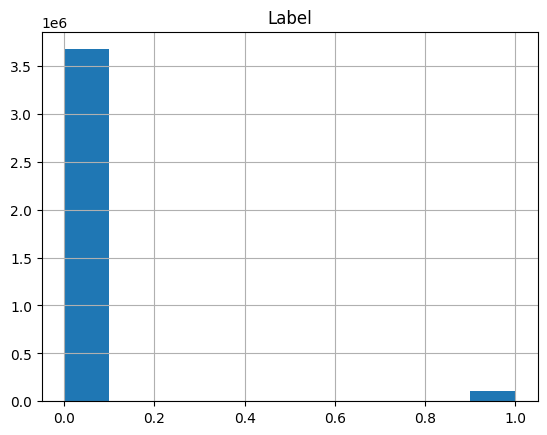

In [8]:
# Convert 'Label' column to integer
# Label count
print(awid_df['Label'].value_counts())
# Show graph
awid_df.hist('Label');

In [9]:
# Drop duplicate rows
awid_df.drop_duplicates(inplace=True)
# Split into X and y
X, y = split_X_y(awid_df)
# Drop highly correlated features
X = drop_highly_correlated_features(X)

In [10]:
# Generate and save training and test data
train_data, test_data = generate_train_test_data(X, y, f'{preprocessed_data_path}')

> Training and test data has been saved!
